In [1]:
import tensorflow as tf

# Enable memory growth to prevent full GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth")
    except RuntimeError as e:
        print(f"Error enabling GPU memory growth: {e}")


Enabled GPU memory growth


In [2]:
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Set dataset paths
BASE_PATH = r"C:\Users\karti\Desktop\Projects\DiagnoSphere\Dataset\SkinDisease\SkinDisease"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

In [4]:
# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 22  # Number of skin disease categories
EPOCHS = 25
FINE_TUNE_EPOCHS = 10

In [5]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80-20 Train-Validation Split
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

Found 11128 images belonging to 22 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 2770 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.


In [7]:
# Get class weights to handle imbalance - FIXED VERSION
# Method 1: Manual calculation
counter = dict(zip(train_generator.class_indices.values(), [0] * len(train_generator.class_indices)))
for i in range(len(train_generator.classes)):
    counter[train_generator.classes[i]] += 1

class_weights = {}
total_samples = train_generator.samples
num_classes = len(train_generator.class_indices)

for class_idx, count in counter.items():
    # Formula: total_samples / (num_classes * count)
    class_weights[class_idx] = total_samples / (num_classes * count) if count > 0 else 1.0

In [8]:
# Get class weights using sklearn's built-in function
y_integers = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(zip(np.unique(y_integers), class_weights_array))

print("Class weights:", class_weights)

total_samples = train_generator.samples
num_classes = len(train_generator.class_indices)

Class weights: {0: 1.0648803827751196, 1: 0.844437699195629, 2: 0.5780779220779221, 3: 1.252025202520252, 4: 2.5417999086340797, 5: 1.1548360315483603, 6: 0.626012601260126, 7: 1.2043290043290042, 8: 1.1418017648265955, 9: 2.031398320554947, 10: 1.7502359232463038, 11: 0.7710643015521065, 12: 2.479500891265597, 13: 1.3896103896103895, 14: 0.9113841113841114, 15: 2.0232727272727273, 16: 0.6844630335834666, 17: 0.3829055123529007, 18: 1.1628004179728317, 19: 1.370780980537078, 20: 0.8842975206611571, 21: 1.0901253918495297}


In [9]:
# Load EfficientNetB3 model
base_model = efn.EfficientNetB3(
    weights="imagenet", 
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model layers
base_model.trainable = False

In [10]:
# Build classification model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

# Print model summary
model.summary()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 40  160         ['stem_conv[0][0]']              
                                )                                                             

In [11]:
# Callbacks
checkpoint = ModelCheckpoint(
    "best_skin_disease_model.h5", 
    monitor="val_accuracy", 
    save_best_only=True, 
    mode="max", 
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode="min"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [12]:
# Display class information
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Number of classes: 22
Class indices: {'Acne': 0, 'Actinic_Keratosis': 1, 'Benign_tumors': 2, 'Bullous': 3, 'Candidiasis': 4, 'DrugEruption': 5, 'Eczema': 6, 'Infestations_Bites': 7, 'Lichen': 8, 'Lupus': 9, 'Moles': 10, 'Psoriasis': 11, 'Rosacea': 12, 'Seborrh_Keratoses': 13, 'SkinCancer': 14, 'Sun_Sunlight_Damage': 15, 'Tinea': 16, 'Unknown_Normal': 17, 'Vascular_Tumors': 18, 'Vasculitis': 19, 'Vitiligo': 20, 'Warts': 21}
Training samples: 11128
Validation samples: 2770
Test samples: 1546


In [13]:
print("Starting initial training phase...")
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator, 
        validation_data=validation_generator, 
        epochs=EPOCHS, 
        class_weight=class_weights,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

Starting initial training phase...
Epoch 1/25
348/348 [==============================] - ETA: 0s - loss: 2.8595 - accuracy: 0.1647 - precision: 0.6750 - recall: 0.0024
Epoch 1: val_accuracy improved from -inf to 0.22996, saving model to best_skin_disease_model.h5
348/348 [==============================] - 267s 720ms/step - loss: 2.8595 - accuracy: 0.1647 - precision: 0.6750 - recall: 0.0024 - val_loss: 2.6715 - val_accuracy: 0.2300 - val_precision: 0.5263 - val_recall: 0.0072 - lr: 1.0000e-04
Epoch 2/25
348/348 [==============================] - ETA: 0s - loss: 2.4692 - accuracy: 0.2952 - precision: 0.7721 - recall: 0.0533
Epoch 2: val_accuracy improved from 0.22996 to 0.27690, saving model to best_skin_disease_model.h5
348/348 [==============================] - 232s 666ms/step - loss: 2.4692 - accuracy: 0.2952 - precision: 0.7721 - recall: 0.0533 - val_loss: 2.4528 - val_accuracy: 0.2769 - val_precision: 0.6765 - val_recall: 0.0664 - lr: 1.0000e-04
Epoch 3/25
348/348 [================

In [14]:
print("Starting fine-tuning phase...")
# Unfreeze base model for fine-tuning (only unfreeze last 50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Starting fine-tuning phase...


In [15]:
# Train for fine-tuning
fine_tune_history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=FINE_TUNE_EPOCHS, 
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/10
348/348 [==============================] - ETA: 0s - loss: 2.2247 - accuracy: 0.3534 - precision_1: 0.7013 - recall_1: 0.1432
Epoch 1: val_accuracy did not improve from 0.34296
348/348 [==============================] - 131s 355ms/step - loss: 2.2247 - accuracy: 0.3534 - precision_1: 0.7013 - recall_1: 0.1432 - val_loss: 2.3658 - val_accuracy: 0.2946 - val_precision_1: 0.6469 - val_recall_1: 0.1336 - lr: 1.0000e-05
Epoch 2/10
348/348 [==============================] - ETA: 0s - loss: 2.0190 - accuracy: 0.3989 - precision_1: 0.7677 - recall_1: 0.1803
Epoch 2: val_accuracy did not improve from 0.34296
348/348 [==============================] - 120s 343ms/step - loss: 2.0190 - accuracy: 0.3989 - precision_1: 0.7677 - recall_1: 0.1803 - val_loss: 2.3282 - val_accuracy: 0.2996 - val_precision_1: 0.5988 - val_recall_1: 0.1487 - lr: 1.0000e-05
Epoch 3/10
348/348 [==============================] - ETA: 0s - loss: 1.9235 - accuracy: 0.4206 - precision_1: 0.7775 - recall_1: 0.2120
Epo

In [16]:
# Save final model
model.save("final_skin_disease_classifier.h5")

In [17]:
# Evaluate model on test data
print("Evaluating model on test data...")
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

Evaluating model on test data...
49/49 [==============================] - 27s 544ms/step - loss: 1.7624 - accuracy: 0.4638 - precision_1: 0.7305 - recall_1: 0.3034
Test accuracy: 0.4638
Test precision: 0.7305
Test recall: 0.3034


In [18]:
# Generate predictions for confusion matrix
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

49/49 [==============================] - 12s 202ms/step


In [19]:
# Generate classification report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:
                     precision    recall  f1-score   support

               Acne       0.58      0.71      0.64        65
  Actinic_Keratosis       0.53      0.30      0.38        83
      Benign_tumors       0.48      0.17      0.25       121
            Bullous       0.40      0.33      0.36        55
        Candidiasis       0.33      0.63      0.43        27
       DrugEruption       0.51      0.39      0.44        61
             Eczema       0.44      0.33      0.38       112
 Infestations_Bites       0.31      0.28      0.30        60
             Lichen       0.37      0.30      0.33        61
              Lupus       0.16      0.29      0.21        34
              Moles       0.25      0.45      0.32        40
          Psoriasis       0.44      0.36      0.40        88
            Rosacea       0.30      0.75      0.43        28
  Seborrh_Keratoses       0.39      0.53      0.45        51
         SkinCancer       0.47      0.35      0.40        77


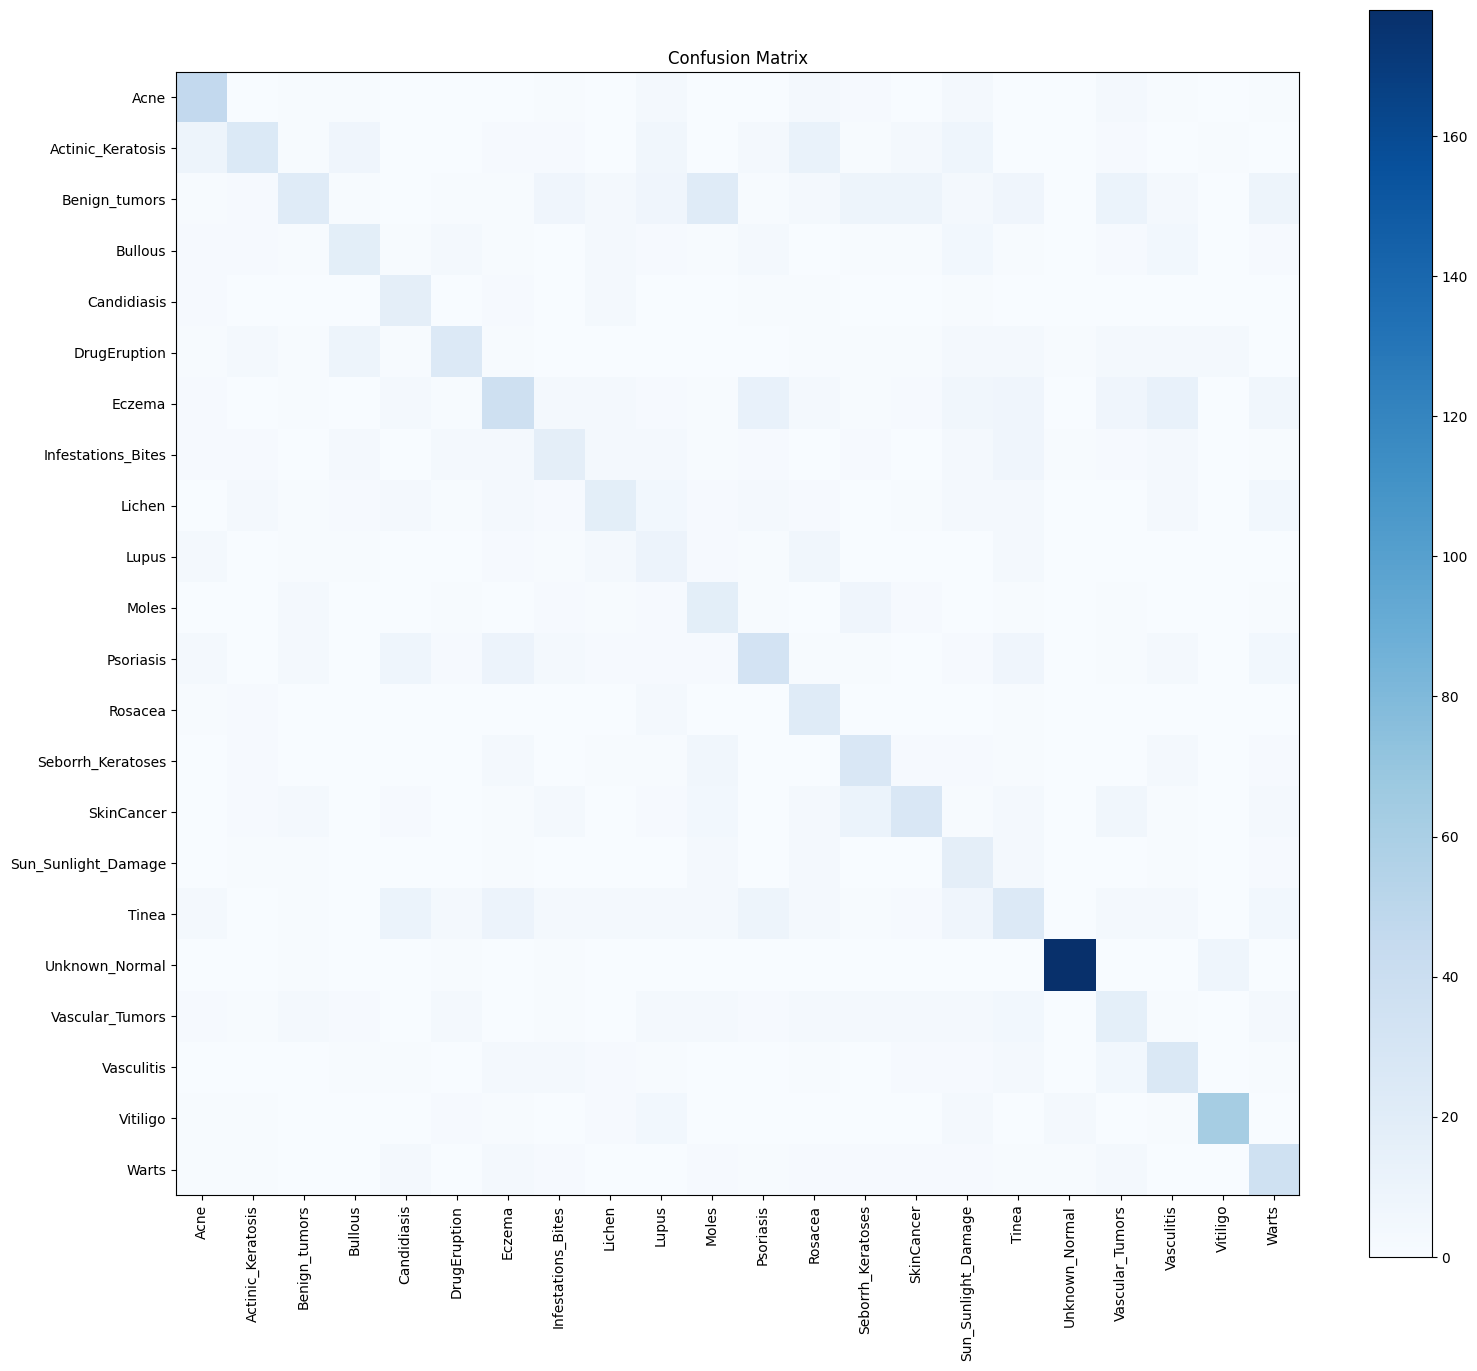

In [20]:
# Plot confusion matrix
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_true, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)
plt.tight_layout()
plt.savefig('confusion_matrix.png')

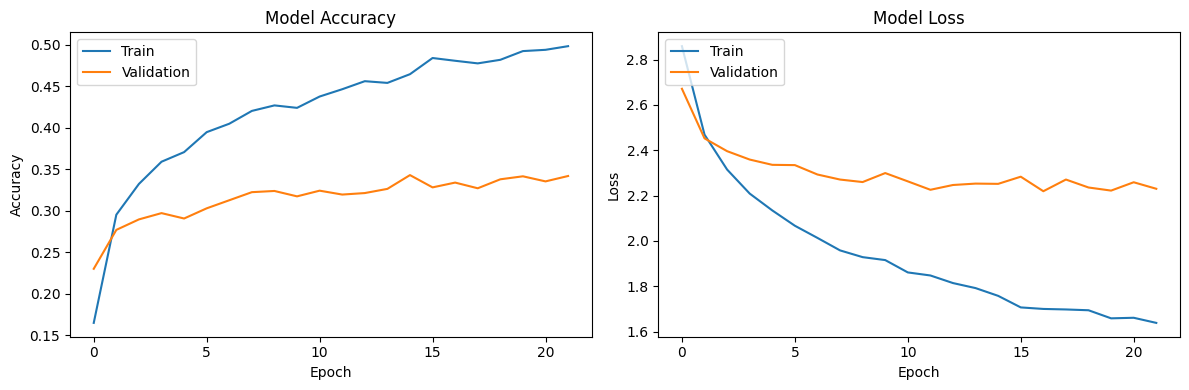

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('training_history.png')

In [22]:
# Save model architecture as image if pydot and graphviz are installed
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture saved as image.")
except:
    print("Couldn't save model architecture as image. Install pydot and graphviz if needed.")

print("Training complete! Model saved and evaluated.")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model architecture saved as image.
Training complete! Model saved and evaluated.
